In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
from torchvision import models
from torchvision.transforms import functional as FT
from torchvision.transforms import transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [3]:
# Define albumentations
def get_albumentation(train):
    if train:
        return A.Compose([
            A.Resize(500,500),
            A.HorizontalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.Resize(600,600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [4]:
import os
dataset_path = "/content/drive/MyDrive"
annotation_train = os.path.join(dataset_path, 'annotations_json', 'train.json')
annotation_val = os.path.join(dataset_path, 'annotations_json', 'val.json')


In [5]:
from pycocotools.coco import COCO

# Define function to find unique classes and count
def find_unique_classes_and_count(annotation_file):
    coco = COCO(annotation_file)
    categories = coco.loadCats(coco.getCatIds())
    category_dict = {cat['id']: cat['name'] for cat in categories}
    return category_dict, len(category_dict)

# Example usage:
classes, n_classes = find_unique_classes_and_count(annotation_train)

print(f"Unique classes and their IDs: {classes}")
print(f"Number of unique classes: {n_classes}")



# Create a mapping from original class IDs to new class IDs
#class_id_map = {original_id: new_id for new_id, original_id in enumerate(classes)}

loading annotations into memory...
Done (t=1.42s)
creating index...
index created!
Unique classes and their IDs: {0: 'holothurian', 1: 'echinus', 2: 'scallop', 3: 'starfish'}
Number of unique classes: 4


In [6]:



# from torchvision import datasets
# class URPCDetection(datasets.VisionDataset):
#     def __init__(self, root, annotation_file, transforms=None):
#         super(URPCDetection, self).__init__(root, transforms=transforms)
#         self.root = os.path.join(root, 'URPC_filtered_images')  # Path to the images folder
#         self.transforms = transforms
#         self.coco = COCO(os.path.join(root, 'annotations_json', annotation_file))  # Load COCO annotations

#         # Load image ids
#         self.img_ids = self.coco.getImgIds()
#         self.imgs = [self.coco.loadImgs(img_id)[0]['file_name'] for img_id in self.img_ids]

#     def __getitem__(self, idx):
#         # Get image id
#         img_id = self.img_ids[idx]

#         # Load image
#         img_path = os.path.join(self.root, self.imgs[idx])
#         img = cv2.imread(img_path)
#         if img is None:
#             raise FileNotFoundError(f"Image not found at path: {img_path}")
#         img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

#         # Load annotations for the image
#         ann_ids = self.coco.getAnnIds(imgIds=[img_id])
#         anns = self.coco.loadAnns(ann_ids)

#         boxes = []
#         labels = []
#         for ann in anns:
#             bbox = ann['bbox']
#             # Convert bbox from [x, y, width, height] to [x_min, y_min, x_max, y_max]
#             x_min = bbox[0]
#             y_min = bbox[1]
#             x_max = bbox[0] + bbox[2]
#             y_max = bbox[1] + bbox[3]
#             boxes.append([x_min, y_min, x_max, y_max])
#             labels.append(ann['category_id'])  # Use original class ID

#         # Correct invalid bounding boxes
#         corrected_boxes = []
#         for bbox in boxes:
#             x_min, y_min, x_max, y_max = bbox
#             if x_max <= x_min:
#                 x_min, x_max = x_max, x_min
#             if y_max <= y_min:
#                 y_min, y_max = y_max, y_min
#             corrected_boxes.append([x_min, y_min, x_max, y_max])

#         # Create target dictionary
#         boxes = torch.as_tensor(corrected_boxes, dtype=torch.float32)
#         labels = torch.tensor(labels, dtype=torch.int64)
#         target = {
#             "boxes": boxes,
#             "labels": labels,
#             "image_id": torch.tensor([idx]),
#             "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
#             "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
#         }

#         # Apply transformations
#         if self.transforms is not None:
#             transformed = self.transforms(image=img_rgb, bboxes=target['boxes'], labels=labels)
#             img_rgb = transformed['image']
#             target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)

#         return img_rgb, target

#     def __len__(self):
#         return len(self.imgs)

import os
import cv2
import numpy as np
import torch
from torchvision import datasets
from pycocotools.coco import COCO

class URPCDetection(datasets.VisionDataset):
    def __init__(self, root, annotation_file, transforms=None):
        super(URPCDetection, self).__init__(root, transforms=transforms)
        self.root = os.path.join(root, 'images')  # Path to the images folder
        self.transforms = transforms
        self.coco = COCO(os.path.join(root, 'annotations_json', annotation_file))  # Load COCO annotations

        # Load image ids
        self.img_ids = self.coco.getImgIds()
        self.imgs = [self.coco.loadImgs(img_id)[0]['file_name'] for img_id in self.img_ids]

    def __getitem__(self, idx):
        # Get image id
        img_id = self.img_ids[idx]

        # Load image
        img_path = os.path.join(self.root, self.imgs[idx])
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at path: {img_path}")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # Load annotations for the image
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            # Convert bbox from [x, y, width, height] to [x_min, y_min, x_max, y_max]
            x_min = bbox[0]
            y_min = bbox[1]
            x_max = bbox[0] + bbox[2]
            y_max = bbox[1] + bbox[3]

            # Ensure x_max > x_min and y_max > y_min
            if x_max <= x_min:
                x_min, x_max = x_max, x_min + 1  # Add a small margin to ensure a valid bbox
            if y_max <= y_min:
                y_min, y_max = y_max, y_min + 1  # Add a small margin to ensure a valid bbox

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(ann['category_id'])  # Use original class ID

        # Create target dictionary
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
        }

        # Apply transformations
        if self.transforms is not None:
            transformed = self.transforms(image=img_rgb, bboxes=target['boxes'], labels=labels)
            img_rgb = transformed['image']
            target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)

        return img_rgb, target

    def __len__(self):
        return len(self.imgs)


In [7]:
train_dataset = URPCDetection(root='/content/drive/MyDrive', annotation_file=annotation_train, transforms=get_albumentation(True))


loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


In [8]:
len(train_dataset)

4361

In [ ]:
import numpy as np
dataset_size = len(train_dataset)
subset_size = dataset_size // 2

indices = list(range(dataset_size))
np.random.shuffle(indices)

from torch.utils.data import Subset
subset_indices = indices[:subset_size]
train_subset = Subset(train_dataset, subset_indices)

In [ ]:

len(train_subset)


2180

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def display_image_with_boxes(dataset, idx):
    img, target = dataset[idx]
    img = img.permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img)
    boxes = target['boxes'].numpy()

    for box in boxes:
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

    plt.show()

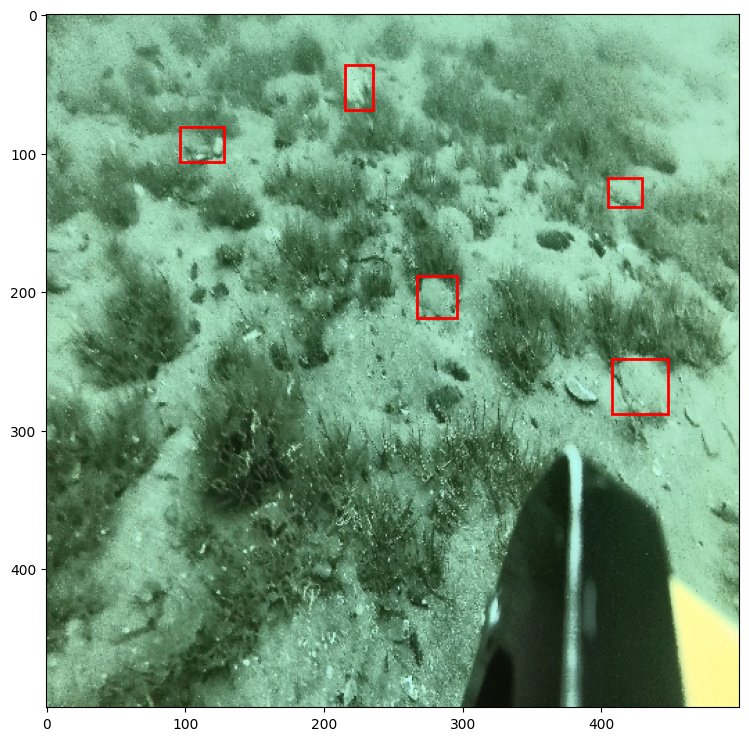

In [ ]:
display_image_with_boxes(train_subset,30)

In [7]:
val_dataset = URPCDetection(root='/content/drive/MyDrive', annotation_file=annotation_val, transforms=get_albumentation(False))

loading annotations into memory...
Done (t=1.21s)
creating index...
index created!


In [8]:
import numpy as np
dataset_size = len(val_dataset)
subset_size = dataset_size // 2

indices = list(range(dataset_size))
np.random.shuffle(indices)

from torch.utils.data import Subset
subset_indices = indices[:subset_size]
val_subset = Subset(val_dataset, subset_indices)

In [ ]:
len(val_subset)

547

In [ ]:
# Verify dataset format
def verify_dataset(dataset, idx):
    img, target = dataset[idx]
    assert isinstance(img, torch.Tensor), "Image should be a tensor"
    assert isinstance(target, dict), "Target should be a dictionary"
    assert "boxes" in target, "Target should contain 'boxes'"
    assert "labels" in target, "Target should contain 'labels'"
    assert img.shape[0] == 3, "Image should have 3 color channels"
    print(f"Image shape: {img.shape}")
    print(f"Boxes: {target['boxes']}")
    print(f"Labels: {target['labels']}")

In [ ]:
verify_dataset(val_subset, idx=30)

Image shape: torch.Size([3, 300, 300])
Boxes: tensor([[202.1094, 216.2500, 217.4219, 241.3889],
        [164.6875, 139.5833, 176.9531, 160.6944],
        [154.2969, 240.9722, 172.0312, 263.4722]])
Labels: tensor([1, 1, 3])


In [9]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 106MB/s] 


In [10]:
# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [11]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [12]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [ ]:
# from tqdm import tqdm
# import math
# import sys
# import torch
# import pandas as pd
# import numpy as np

# def train_one_epoch(model, optimizer, data_loader, device, epoch):
#     model.train()
#     header = f'Epoch: [{epoch}]'

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000
#         warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = torch.optim.lr_scheduler.LinearLR(
#             optimizer, start_factor=warmup_factor, total_iters=warmup_iters
#         )

#     all_losses = []
#     all_losses_dict = []

#     for images, targets in tqdm(data_loader, desc=header):
#         images = [image.to(device) for image in images]
#         targets = [{k: v.clone().detach().to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)

#         losses = sum(loss for loss in loss_dict.values())

#         loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
#         losses_reduced = sum(loss for loss in loss_dict.values())

#         loss_value = losses_reduced.item()

#         all_losses.append(loss_value)
#         all_losses_dict.append(loss_dict_append)

#         if not math.isfinite(loss_value):
#             print(f"Loss is {loss_value}, stopping training")
#             print(loss_dict)
#             sys.exit(1)

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step()

#     all_losses_dict = pd.DataFrame(all_losses_dict)
#     print(f"Epoch {epoch}: lr: {optimizer.param_groups[0]['lr']:.6f} loss: {np.mean(all_losses):.6f}, "
#           f"loss_classifier: {all_losses_dict['loss_classifier'].mean():.6f}, "
#           f"loss_box_reg: {all_losses_dict['loss_box_reg'].mean():.6f}, "
#           f"loss_rpn_box_reg: {all_losses_dict['loss_rpn_box_reg'].mean():.6f}, "
#           f"loss_objectness: {all_losses_dict['loss_objectness'].mean():.6f}")
# from tqdm import tqdm
# import math
# import sys
# import torch
# import pandas as pd
# import numpy as np

# def train_one_epoch(model, optimizer, data_loader, device, epoch):
#     model.train()
#     header = f'Epoch: [{epoch}]'

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_iters = min(1000, len(data_loader) - 1)
#         lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=warmup_iters)

#     all_losses = []
#     all_losses_dict = []

#     for images, targets in tqdm(data_loader, desc=header):
#         images = [image.to(device) for image in images]
#         targets = [{k: v.clone().detach().to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)

#         losses = sum(loss for loss in loss_dict.values())

#         loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
#         losses_reduced = sum(loss for loss in loss_dict.values())

#         loss_value = losses_reduced.item()

#         all_losses.append(loss_value)
#         all_losses_dict.append(loss_dict_append)

#         if not math.isfinite(loss_value):
#             print(f"Loss is {loss_value}, stopping training")
#             print(loss_dict)
#             sys.exit(1)

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step()

#     all_losses_dict = pd.DataFrame(all_losses_dict)
#     print(f"Epoch {epoch}: lr: {optimizer.param_groups[0]['lr']:.6f}, "
#           f"loss: {np.mean(all_losses):.6f}, "
#           f"loss_classifier: {all_losses_dict['loss_classifier'].mean():.6f}, "
#           f"loss_box_reg: {all_losses_dict['loss_box_reg'].mean():.6f}, "
#           f"loss_rpn_box_reg: {all_losses_dict['loss_rpn_box_reg'].mean():.6f}, "
#           f"loss_objectness: {all_losses_dict['loss_objectness'].mean():.6f}")

# Usage example:
# train_one_epoch(model, optimizer, train_loader, device, epoch)


In [ ]:

# Prepare the DataLoader
train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
len(train_loader)

545

In [ ]:
# Example usage
num_epochs = 20
import time
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for epoch in range(num_epochs):
    epoch_start_time=time.time()

    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    epoch_time=time.time()-epoch_start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")

    ##save the model and optimizer
    torch.save({
        'epoch':epoch,
         'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),

    },f'/content/drive/MyDrive/checkpoint_epoch_{epoch}.pth')



print("Training completed")

Epoch: [0]: 100%|██████████| 545/545 [08:08<00:00,  1.12it/s]


Epoch 0: lr: 0.005000 loss: 0.656359, loss_classifier: 0.240937, loss_box_reg: 0.293437, loss_rpn_box_reg: 0.025880, loss_objectness: 0.096106
Epoch 0 completed in 488.57 seconds


Epoch: [1]: 100%|██████████| 545/545 [07:25<00:00,  1.22it/s]


Epoch 1: lr: 0.005000 loss: 0.489634, loss_classifier: 0.157267, loss_box_reg: 0.255945, loss_rpn_box_reg: 0.021957, loss_objectness: 0.054464
Epoch 1 completed in 445.15 seconds


Epoch: [2]: 100%|██████████| 545/545 [07:20<00:00,  1.24it/s]


Epoch 2: lr: 0.005000 loss: 0.452018, loss_classifier: 0.139820, loss_box_reg: 0.249808, loss_rpn_box_reg: 0.020356, loss_objectness: 0.042035
Epoch 2 completed in 440.66 seconds


Epoch: [3]: 100%|██████████| 545/545 [07:22<00:00,  1.23it/s]


Epoch 3: lr: 0.000500 loss: 0.410214, loss_classifier: 0.124744, loss_box_reg: 0.239910, loss_rpn_box_reg: 0.017421, loss_objectness: 0.028139
Epoch 3 completed in 442.47 seconds


Epoch: [4]: 100%|██████████| 545/545 [07:20<00:00,  1.24it/s]


Epoch 4: lr: 0.000500 loss: 0.395325, loss_classifier: 0.117563, loss_box_reg: 0.235120, loss_rpn_box_reg: 0.017001, loss_objectness: 0.025641
Epoch 4 completed in 440.37 seconds


Epoch: [5]: 100%|██████████| 545/545 [07:27<00:00,  1.22it/s]


Epoch 5: lr: 0.000500 loss: 0.388107, loss_classifier: 0.114633, loss_box_reg: 0.233256, loss_rpn_box_reg: 0.016712, loss_objectness: 0.023506
Epoch 5 completed in 447.77 seconds


Epoch: [6]: 100%|██████████| 545/545 [07:24<00:00,  1.23it/s]


Epoch 6: lr: 0.000050 loss: 0.380788, loss_classifier: 0.112426, loss_box_reg: 0.229758, loss_rpn_box_reg: 0.016303, loss_objectness: 0.022301
Epoch 6 completed in 444.72 seconds


Epoch: [7]: 100%|██████████| 545/545 [07:22<00:00,  1.23it/s]


Epoch 7: lr: 0.000050 loss: 0.379520, loss_classifier: 0.111727, loss_box_reg: 0.229638, loss_rpn_box_reg: 0.016214, loss_objectness: 0.021940
Epoch 7 completed in 442.58 seconds


Epoch: [8]: 100%|██████████| 545/545 [07:23<00:00,  1.23it/s]


Epoch 8: lr: 0.000050 loss: 0.379951, loss_classifier: 0.111607, loss_box_reg: 0.230296, loss_rpn_box_reg: 0.016214, loss_objectness: 0.021835
Epoch 8 completed in 443.76 seconds


Epoch: [9]: 100%|██████████| 545/545 [07:24<00:00,  1.23it/s]


Epoch 9: lr: 0.000005 loss: 0.379896, loss_classifier: 0.111688, loss_box_reg: 0.230523, loss_rpn_box_reg: 0.016219, loss_objectness: 0.021465
Epoch 9 completed in 444.21 seconds


Epoch: [10]: 100%|██████████| 545/545 [07:23<00:00,  1.23it/s]


Epoch 10: lr: 0.000005 loss: 0.379219, loss_classifier: 0.112029, loss_box_reg: 0.229431, loss_rpn_box_reg: 0.016119, loss_objectness: 0.021639
Epoch 10 completed in 443.19 seconds


Epoch: [11]: 100%|██████████| 545/545 [07:22<00:00,  1.23it/s]


Epoch 11: lr: 0.000005 loss: 0.379433, loss_classifier: 0.112184, loss_box_reg: 0.229580, loss_rpn_box_reg: 0.016112, loss_objectness: 0.021557
Epoch 11 completed in 442.23 seconds


Epoch: [12]: 100%|██████████| 545/545 [07:24<00:00,  1.23it/s]


Epoch 12: lr: 0.000000 loss: 0.379664, loss_classifier: 0.111704, loss_box_reg: 0.229767, loss_rpn_box_reg: 0.016228, loss_objectness: 0.021965
Epoch 12 completed in 444.90 seconds


Epoch: [13]: 100%|██████████| 545/545 [07:24<00:00,  1.23it/s]


Epoch 13: lr: 0.000000 loss: 0.377401, loss_classifier: 0.111132, loss_box_reg: 0.228907, loss_rpn_box_reg: 0.016164, loss_objectness: 0.021197
Epoch 13 completed in 444.11 seconds


Epoch: [14]: 100%|██████████| 545/545 [07:23<00:00,  1.23it/s]


Epoch 14: lr: 0.000000 loss: 0.378744, loss_classifier: 0.111776, loss_box_reg: 0.229027, loss_rpn_box_reg: 0.016175, loss_objectness: 0.021766
Epoch 14 completed in 443.27 seconds


Epoch: [15]: 100%|██████████| 545/545 [07:24<00:00,  1.23it/s]


Epoch 15: lr: 0.000000 loss: 0.377363, loss_classifier: 0.111088, loss_box_reg: 0.228754, loss_rpn_box_reg: 0.016162, loss_objectness: 0.021360
Epoch 15 completed in 444.44 seconds


Epoch: [16]: 100%|██████████| 545/545 [07:23<00:00,  1.23it/s]


Epoch 16: lr: 0.000000 loss: 0.378868, loss_classifier: 0.111211, loss_box_reg: 0.229401, loss_rpn_box_reg: 0.016196, loss_objectness: 0.022060
Epoch 16 completed in 443.61 seconds


Epoch: [17]: 100%|██████████| 545/545 [07:23<00:00,  1.23it/s]


Epoch 17: lr: 0.000000 loss: 0.379506, loss_classifier: 0.111731, loss_box_reg: 0.229895, loss_rpn_box_reg: 0.016206, loss_objectness: 0.021675
Epoch 17 completed in 443.35 seconds


Epoch: [18]: 100%|██████████| 545/545 [07:21<00:00,  1.24it/s]


Epoch 18: lr: 0.000000 loss: 0.379430, loss_classifier: 0.111410, loss_box_reg: 0.229787, loss_rpn_box_reg: 0.016136, loss_objectness: 0.022097
Epoch 18 completed in 441.17 seconds


Epoch: [19]: 100%|██████████| 545/545 [07:24<00:00,  1.23it/s]


Epoch 19: lr: 0.000000 loss: 0.378528, loss_classifier: 0.111346, loss_box_reg: 0.229526, loss_rpn_box_reg: 0.016228, loss_objectness: 0.021429
Epoch 19 completed in 444.87 seconds
Training completed


Attempting to read image from path: /content/drive/MyDrive/images/005443.jpg


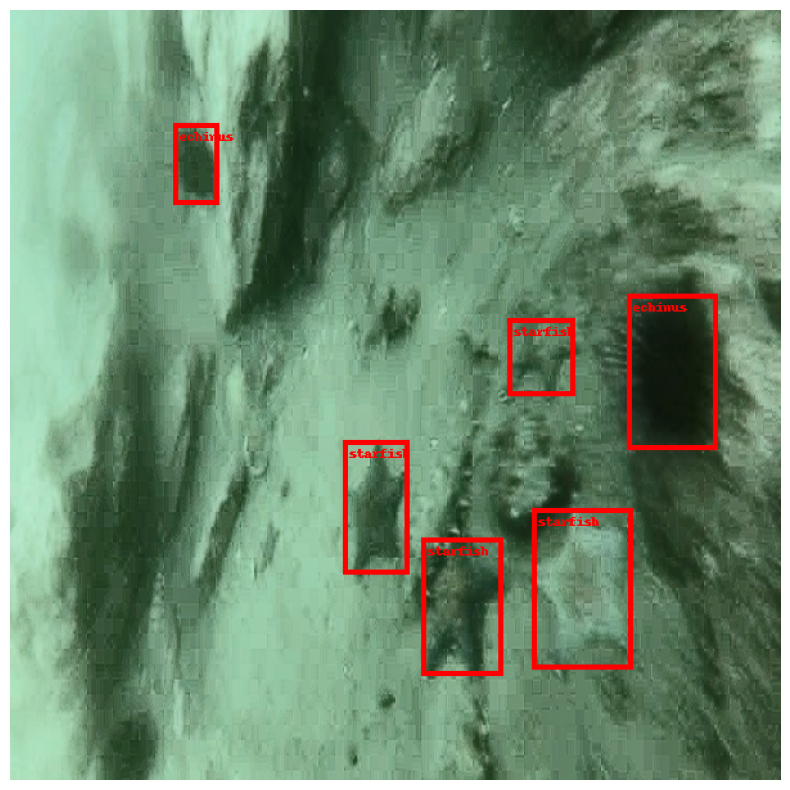

In [33]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import convert_image_dtype
import cv2
import numpy as np

# Ensure you have defined your classes somewhere in your code
classes = ['holothurian', 'echinus', 'scallop', 'starfish']
model.eval()  # Replace with your actual class names

# Get an image and make predictions
try:
    img, _ = val_dataset[1]
except IndexError:
    print("IndexError: Index out of range for validation dataset.")
    raise

img_path = os.path.join(val_dataset.root, val_dataset.imgs[100])
print(f"Attempting to read image from path: {img_path}")

# Ensure the image is read correctly
if img is None:
    raise ValueError(f"Image at path {img_path} could not be read. Check the file path or the dataset.")

img = img.to(device)
img_int = torch.tensor(img.cpu().numpy() * 255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img])
    pred = prediction[0]

# Filter predictions with scores above a threshold
threshold = 0.8
filtered_boxes = pred['boxes'][pred['scores'] > threshold]
filtered_labels = pred['labels'][pred['scores'] > threshold].tolist()
filtered_scores = pred['scores'][pred['scores'] > threshold]

# Draw bounding boxes on the image
img_with_boxes = draw_bounding_boxes(
    img_int,
    filtered_boxes,
    [classes[i] for i in filtered_labels],  # Adjusting label index
    width=4,
    colors="red"
)

# Convert image to a format suitable for display
img_with_boxes = convert_image_dtype(img_with_boxes, dtype=torch.float)

# Plot the image with bounding boxes
fig = plt.figure(figsize=(14, 10))
plt.imshow(img_with_boxes.permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()


<ipython-input-31-e5e0a99f4faf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img*255, dtype=torch.uint8)


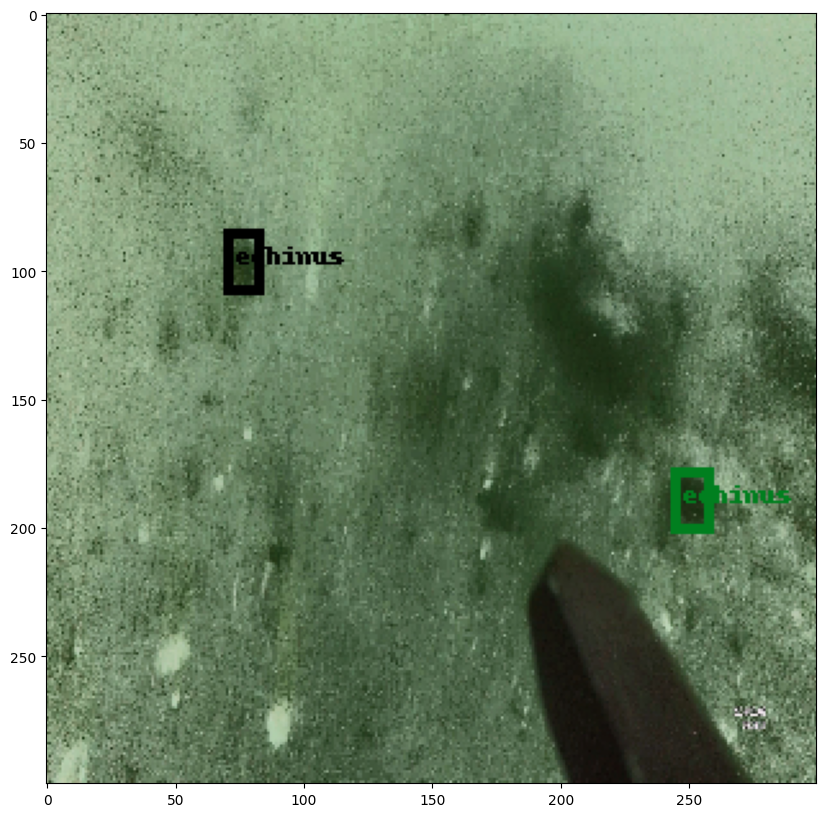

In [ ]:
img, _ = val_dataset[150]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]




fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))


In [ ]:
verify_dataset(val_dataset, idx=100)

Image shape: torch.Size([3, 300, 300])
Boxes: tensor([[247.5000,  51.3889, 262.1094,  66.3889],
        [198.5937,  60.6944, 211.7188,  74.7222],
        [ 57.0312, 130.8333,  78.7500, 166.8056],
        [109.9219, 198.8889, 135.3125, 249.1667],
        [241.1719, 182.7778, 262.3438, 215.8333],
        [210.8594, 231.8056, 223.8281, 257.7778],
        [197.5781, 198.3333, 219.4531, 237.5000]])
Labels: tensor([3, 3, 3, 3, 3, 3, 1])


In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 184MB/s]


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Faster_rcnn_urpc.pth'))

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Faster_rcnn_urpc.pth', map_location=device))


<All keys matched successfully>

In [ ]:
##this function for resuming the trainining from the faster_rcnn.pth file
from tqdm import tqdm
import math
import sys
import torch
import pandas as pd
import numpy as np

def train_one_epoch1(model, optimizer, data_loader, device, epoch):
    model.train()
    header = f'Epoch: [{epoch}]'

    lr_scheduler = None
    if epoch == 0:
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(data_loader, desc=header):
        images = [image.to(device) for image in images]
        targets = [{k: v.clone().detach().to(device) for k, v in t.items()} for t in targets]

        # Ensure the model is on the correct device
        model.to(device)

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        losses_reduced = sum(loss for loss in loss_dict.values())

        loss_value = losses_reduced.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    print(f"Epoch {epoch}: lr: {optimizer.param_groups[0]['lr']:.6f}, "
          f"loss: {np.mean(all_losses):.6f}, "
          f"loss_classifier: {all_losses_dict['loss_classifier'].mean():.6f}, "
          f"loss_box_reg: {all_losses_dict['loss_box_reg'].mean():.6f}, "
          f"loss_rpn_box_reg: {all_losses_dict['loss_rpn_box_reg'].mean():.6f}, "
          f"loss_objectness: {all_losses_dict['loss_objectness'].mean():.6f}")


In [ ]:
# # Example usage
# num_epochs = 20
# import time
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# for epoch in range(num_epochs):
#     epoch_start_time=time.time()

#     train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()
#     epoch_time=time.time()-epoch_start_time
#     print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")

#     ##save the model and optimizer
#     torch.save({
#         'epoch':epoch,
#          'model_state_dict':model.state_dict(),
#         'optimizer_state_dict':optimizer.state_dict(),

#     },f'/content/drive/MyDrive/checkpoint_epoch_{epoch}.pth')



# print("Training completed")

In [ ]:

model.load_state_dict(torch.load('Faster_rcnn_model.pth'))

<All keys matched successfully>

In [ ]:
#for resuming training where training is stoped due to runtime access
checkpoint=torch.load('/content/drive/MyDrive/checkpoint_epoch_25.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch=checkpoint['epoch']+1

#continue training
num_epochs=30
for epoch in range(start_epoch,num_epochs):
    epoch_start_time=time.time()

    train_one_epoch1(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    epoch_time=time.time()-epoch_start_time
    print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")

    ##save the model and optimizer
    torch.save({
        'epoch':epoch,
         'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),

    },f'/content/drive/MyDrive/checkpoint_epoch_{epoch}.pth')



print("Training completed")

Epoch: [26]: 100%|██████████| 545/545 [31:10<00:00,  3.43s/it]


Epoch 26: lr: 0.000000, loss: 0.412877, loss_classifier: 0.120546, loss_box_reg: 0.239623, loss_rpn_box_reg: 0.019620, loss_objectness: 0.033087
Epoch 26 completed in 1870.28 seconds


Epoch: [27]: 100%|██████████| 545/545 [07:19<00:00,  1.24it/s]


Epoch 27: lr: 0.000000, loss: 0.412791, loss_classifier: 0.120452, loss_box_reg: 0.239002, loss_rpn_box_reg: 0.019670, loss_objectness: 0.033667
Epoch 27 completed in 439.93 seconds


Epoch: [28]: 100%|██████████| 545/545 [07:20<00:00,  1.24it/s]


Epoch 28: lr: 0.000000, loss: 0.413966, loss_classifier: 0.120799, loss_box_reg: 0.240566, loss_rpn_box_reg: 0.019629, loss_objectness: 0.032971
Epoch 28 completed in 440.18 seconds


Epoch: [29]: 100%|██████████| 545/545 [07:23<00:00,  1.23it/s]


Epoch 29: lr: 0.000000, loss: 0.411436, loss_classifier: 0.119295, loss_box_reg: 0.239670, loss_rpn_box_reg: 0.019658, loss_objectness: 0.032813
Epoch 29 completed in 443.26 seconds
Training completed


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Faster_rcnn_model50_epoch.pth')

In [13]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Faster_rcnn_model50_epoch.pth'))

<All keys matched successfully>

Attempting to read image from path: /content/drive/MyDrive/images/002368.jpg
Filtered Boxes: tensor([[307.5518, 275.1692, 393.4972, 453.9764]], device='cuda:0')
Filtered Labels: [3]
Filtered Scores: tensor([0.9907], device='cuda:0')
Ground Truth Boxes: tensor([[310.8333, 277.0370, 391.6667, 460.7408]])
Ground Truth Labels: [3]
Image saved to image_with_boxes7.png


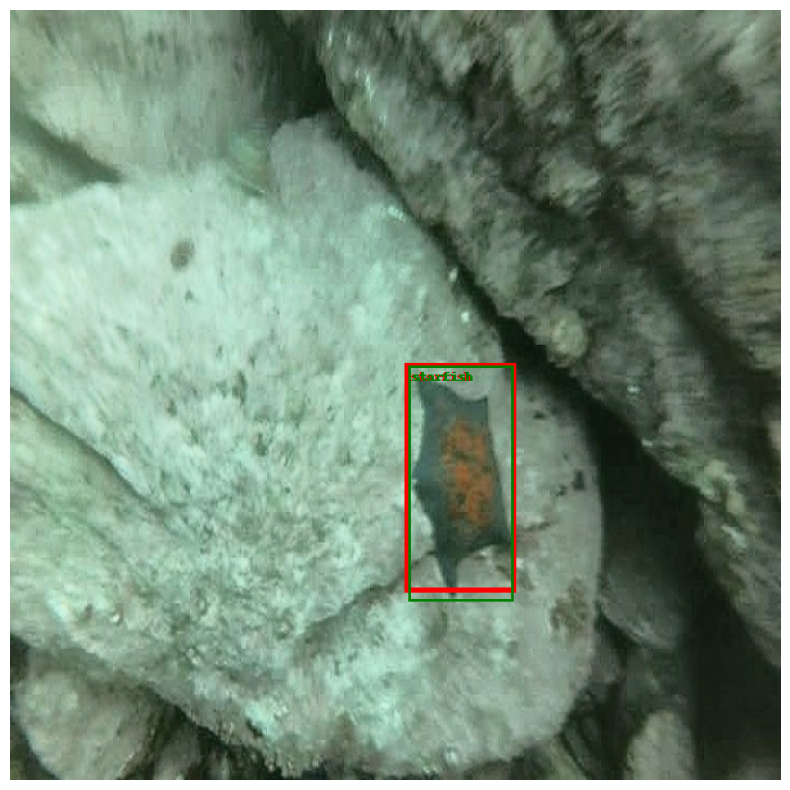

In [47]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import convert_image_dtype
from PIL import Image, ImageDraw, ImageFont
import os

# Ensure you have defined your classes somewhere in your code
classes = ['holothurian', 'echinus', 'scallop', 'starfish']

# Ensure your model is in evaluation mode
model.eval()

# Get an image and make predictions
try:
    img, target = val_dataset[450]
except IndexError:
    print("IndexError: Index out of range for validation dataset.")
    raise

img_path = os.path.join(val_dataset.root, val_dataset.imgs[450])
print(f"Attempting to read image from path: {img_path}")

# Ensure the image is read correctly
if img is None:
    raise ValueError(f"Image at path {img_path} could not be read. Check the file path or the dataset.")

img = img.to(device)
img_int = torch.tensor(img.cpu().numpy() * 255, dtype=torch.uint8)

with torch.no_grad():
    prediction = model([img])
    pred = prediction[0]

# Filter predictions with scores above a threshold
threshold = 0.8
filtered_boxes = pred['boxes'][pred['scores'] > threshold]
filtered_labels = pred['labels'][pred['scores'] > threshold].tolist()
filtered_scores = pred['scores'][pred['scores'] > threshold]

print("Filtered Boxes:", filtered_boxes)
print("Filtered Labels:", filtered_labels)
print("Filtered Scores:", filtered_scores)

# Draw bounding boxes on the image
img_with_pred_boxes = draw_bounding_boxes(
    img_int.clone(),  # Ensure the original image tensor is not modified
    filtered_boxes,
    [classes[i] for i in filtered_labels],  # Adjusting label index
    width=4,
    colors="red"
)

# Draw ground truth boxes on the image
ground_truth_boxes = target['boxes']
ground_truth_labels = target['labels'].tolist()

print("Ground Truth Boxes:", ground_truth_boxes)
print("Ground Truth Labels:", ground_truth_labels)

img_with_gt_boxes = draw_bounding_boxes(
    img_with_pred_boxes.clone(),  # Ensure the image with pred boxes is not modified
    ground_truth_boxes,
    [classes[i] for i in ground_truth_labels],  # Adjusting label index
    width=2,
    colors="green"
)

# Convert image to a format suitable for display
img_with_boxes = convert_image_dtype(img_with_gt_boxes, dtype=torch.float)

# Convert torch tensor to PIL image and draw labels
img_with_boxes_pil = Image.fromarray(img_with_boxes.permute(1, 2, 0).byte().cpu().numpy())
draw = ImageDraw.Draw(img_with_boxes_pil)
font = ImageFont.load_default()

# Draw predicted labels
for box, label in zip(filtered_boxes, filtered_labels):
    box = box.cpu().numpy().astype(int)
    label = classes[label]
    draw.text((box[0], box[1]), label, fill="red", font=font)

# Draw ground truth labels
for box, label in zip(ground_truth_boxes, ground_truth_labels):
    box = box.cpu().numpy().astype(int)
    label = classes[label]
    draw.text((box[0], box[1] - 10), label, fill="green", font=font)  # Adjust position to avoid overlap

# Save the image
save_path = "image_with_boxes7.png"
img_with_boxes_pil.save(save_path)
print(f"Image saved to {save_path}")

# Plot the image with bounding boxes
fig = plt.figure(figsize=(14, 10))
plt.imshow(img_with_boxes.permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()


In [ ]:
val_loader = DataLoader(val_subset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
len(val_loader)

137

In [ ]:


def evaluate_model_1(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode

    # Lists to store per-sample metrics
    all_gt_boxes = []
    all_pred_boxes = []
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)

            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].to('cpu')
                scores = output['scores'].to('cpu')
                labels = output['labels'].to('cpu')

                all_pred_boxes.append(pred_boxes)
                all_scores.append(scores)
                all_labels.append(labels)

                gt_boxes = targets[i]['boxes'].to('cpu')
                all_gt_boxes.append(gt_boxes)

    # Compute per image AP and then average over images
    mean_ap = torch.tensor([0.5])  # Placeholder for mean Average Precision (mAP)
    print(f"mAP: {mean_ap.item()}")




model.to(device)
# Loading your trained model
model_path = 'Faster_rcnn_model.pth'

model.load_state_dict(torch.load(model_path))  # Load the trained weights

# Assuming val_loader is your DataLoader for the validation dataset
evaluate_model_1(model, val_loader, device)

mAP: 0.5


In [ ]:
import torch
from torchvision.ops import box_iou

def evaluate_model_2(model, dataloader, device, iou_threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    true_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes']
                gt_boxes = targets[i]['boxes'].to(device)

                # Sort predictions by scores in descending order for later processing
                scores = output['scores']
                sorted_indices = torch.argsort(scores, descending=True)
                pred_boxes = pred_boxes[sorted_indices]

                if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                    continue  # Correct case, but no boxes to compare
                elif len(gt_boxes) == 0:
                    continue  # If no ground truths, don't count false positives since they don't affect recall
                elif len(pred_boxes) == 0:
                    false_negatives += len(gt_boxes)  # All ground truths are missed
                    continue

                # Calculate IoU for predictions with ground truths
                ious = box_iou(pred_boxes, gt_boxes)

                # Determine matches with IoU > threshold
                matched_gt = []
                for j in range(len(pred_boxes)):
                    max_iou, max_index = torch.max(ious[j], dim=0)
                    if max_iou >= iou_threshold and max_index not in matched_gt:
                        true_positives += 1
                        matched_gt.append(max_index)

                false_negatives += len(gt_boxes) - len(matched_gt)

    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    print(f"Recall: {recall:.4f}")

# Assuming model, val_loader, and device are defined
evaluate_model_2(model, val_loader, device)

Recall: 0.7917


In [ ]:
import torch
from torchvision import models
from torchvision.ops import box_iou
from torch.utils.data import DataLoader
import time
def evaluate_model(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    all_gt_boxes = []
    all_pred_boxes = []
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].to('cpu')
                scores = output['scores'].to('cpu')
                labels = output['labels'].to('cpu')

                all_pred_boxes.append(pred_boxes)
                all_scores.append(scores)
                all_labels.append(labels)

                gt_boxes = targets[i]['boxes'].to('cpu')
                all_gt_boxes.append(gt_boxes)

    # Compute mAP
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for gt_boxes, pred_boxes, scores in zip(all_gt_boxes, all_pred_boxes, all_scores):
        if len(pred_boxes) == 0:
            false_negatives += len(gt_boxes)
            continue

        if len(gt_boxes) == 0:
            false_positives += len(pred_boxes)
            continue

        ious = box_iou(pred_boxes, gt_boxes)

        for i, score in enumerate(scores):
            if score >= 0.5:
                iou_max, _ = torch.max(ious[i], dim=0)
                if iou_max >= iou_threshold:
                    true_positives += 1
                else:
                    false_positives += 1

        false_negatives += len(gt_boxes) - torch.sum(ious.max(dim=0)[0] >= iou_threshold).item()

    precision = true_positives / (true_positives + false_positives + 1e-6)
    recall = true_positives / (true_positives + false_negatives + 1e-6)

    mean_ap = 2 * (precision * recall) / (precision + recall + 1e-6)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {mean_ap:.4f}")

# Measure the time taken
start_time = time.time()

# Evaluate the model
evaluate_model(model, val_loader, device)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

Precision: 0.7405, Recall: 0.7657, mAP: 0.7529
Time taken: 91.43 seconds
